# Part 4: Sentiment of the artists and communities

### Exercise)  Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8.

In [21]:
# Load graph with genres without including isolated nodes
import json
import networkx as nx
import requests
import gzip
import io
import os

local_network = "data/rock_band_graph_isolated_genres.json.gz"
read_graph_kwargs = {"comments": "#", "delimiter": "|", "create_using": nx.DiGraph()}

if os.path.exists(local_network):
    with gzip.open(local_network, "rt", encoding="utf-8") as fh:
        G_bands = nx.readwrite.node_link_graph(json.load(fh), edges="links")
    print(
        f"Loaded graph with {G_bands.number_of_nodes()} nodes and {G_bands.number_of_edges()} edges containing bands and genres.",
        f"Graph component count: {len(list(nx.weakly_connected_components(G_bands)))}",
        sep="\n",
    )
else:
    print("Graph file not found.")

Loaded graph with 484 nodes and 7323 edges containing bands and genres.
Graph component count: 1


The function to calculate the sentiment score makes use of the dataset (Data Set S1) from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) which contains the average sentiment score of over 10.000 words.

In [26]:
import pandas as pd
import numpy as np
import networkx as nx
import os
# get sentimantal scores from dataset
df = pd.read_csv("data/Data_Set_S1.csv")
word_to_happiness_avg = dict(zip(df["word"], df["happiness_average"]))

def sentiment_score(text: str):
    tokens_lower = text.lower().split()
    scores = [
        word_to_happiness_avg[token] for token in tokens_lower if token in word_to_happiness_avg
    ]
    if scores:
        return sum(scores) / len(scores)
    return None

print("Sentiment dataset statistics:")
print(f"Total words with sentiment scores: {len(word_to_happiness_avg)}")
print(f"Dataset mean sentiment score: {np.mean(list(word_to_happiness_avg.values())):.4f}")
print(f"Dataset percentiles (25%, Median, 75%):", np.percentile(list(word_to_happiness_avg.values()), [25, 50, 75]))

Sentiment dataset statistics:
Total words with sentiment scores: 10208
Dataset mean sentiment score: 5.3749
Dataset percentiles (25%, Median, 75%): [4.9  5.44 6.02]


In [37]:
#min and max sentiment scores in dataset
print(f"Dataset min sentiment score: {min(word_to_happiness_avg.values())}")
print(f"Dataset max sentiment score: {max(word_to_happiness_avg.values())}")

Dataset min sentiment score: 1.3
Dataset max sentiment score: 8.5


### Calculate band sentiment score

To prevent fetching all of the bands wikipage in this notebook, we have exported the band sentiment scores which has been calculated using the function above.

This makes it simple to update our existing network and simply add an additional node property


In [27]:
local_network = "data/band_sentiment_scores.json.gz"
if os.path.exists(local_network):
    with gzip.open(local_network, "rt", encoding="utf-8") as fh:
        band_sentiment_scores: dict = json.load(fh)
    print(f"Loaded sentiment scores for {len(band_sentiment_scores)} bands.")
else:
    print("Sentiment scores file not found.")

for band, score in band_sentiment_scores.items():    
    if band in G_bands:
        G_bands.nodes[band]["sentiment"] = score
print(f"Verify band sentiment score: AC/DC score: {G_bands.nodes['AC/DC']['sentiment']}")


Loaded sentiment scores for 484 bands.
Verify band sentiment score: AC/DC score: 5.515908244826454


We use only the nodes with genres as in part 2 to end up with comparable results.

In [ ]:
# Convert to undirected graph
G_undirected = G_bands.to_undirected()

# Keep only nodes with genre information
nodes_with_genres_list = [
    node
    for node in G_undirected.nodes()
    if "genres" in G_undirected.nodes[node] and G_undirected.nodes[node]["genres"]
]

G_genres = G_undirected.subgraph(nodes_with_genres_list).copy()
print(G_genres)


Graph with 482 nodes and 6003 edges


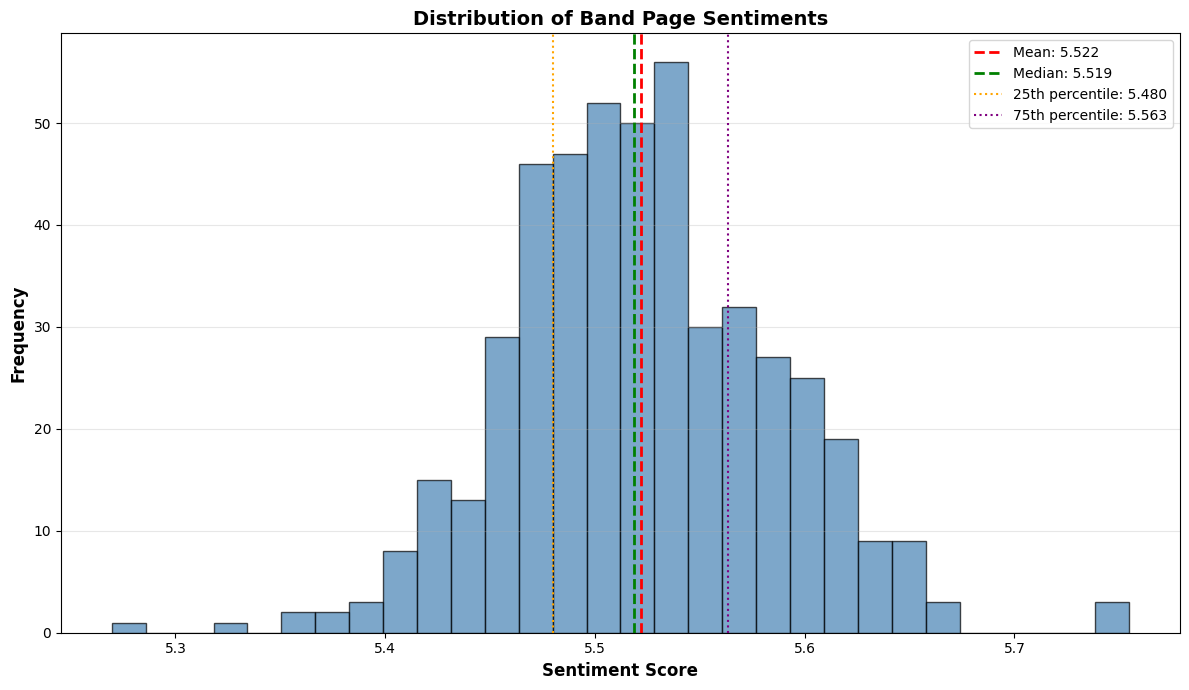

In [29]:
import matplotlib.pyplot as plt

# Calculate statistics
band_sentiments = [
    G_genres.nodes[node]["sentiment"]
    for node in G_genres.nodes()
]
mean_sentiment = round(np.mean(band_sentiments), 4)
median_sentiment = round(np.median(band_sentiments), 4)
p25_sentiment = round(np.percentile(band_sentiments, 25), 4)
p75_sentiment = round(np.percentile(band_sentiments, 75), 4)

# Create figure and plot
fig, ax = plt.subplots(figsize=(12, 7))

# Histogram
ax.hist(band_sentiments, bins=30, color="steelblue", edgecolor="black", alpha=0.7)

# Add vertical lines for statistics
ax.axvline(mean_sentiment, color="red", linestyle="--", linewidth=2, label=f"Mean: {mean_sentiment:.3f}")
ax.axvline(median_sentiment, color="green", linestyle="--", linewidth=2, label=f"Median: {median_sentiment:.3f}")
ax.axvline(p25_sentiment, color="orange", linestyle=":", linewidth=1.5, label=f"25th percentile: {p25_sentiment:.3f}")
ax.axvline(p75_sentiment, color="purple", linestyle=":", linewidth=1.5,label=f"75th percentile: {p75_sentiment:.3f}")

# Labels and title
ax.set_xlabel("Sentiment Score", fontsize=12, fontweight="bold")
ax.set_ylabel("Frequency", fontsize=12, fontweight="bold")
ax.set_title("Distribution of Band Page Sentiments", fontsize=14, fontweight="bold")
ax.legend(fontsize=10, loc="upper right")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

The histogram shows the distribution of sentiment scores across bands, which follows an approximately **normal distribution** centered around a mean of **5.522**.  
This value is very close to the mean sentiment score of the overall sentiment dataset (**5.375**).  
The sentiment scores among bands range from **5.3 to 5.8**, indicating a **very small variance** and suggesting that bands are described with relatively similar sentiment levels.  
In contrast, the full sentiment dataset spans a much wider range (from **1.3 to 8.5**) reflecting a **broader diversity of word sentiments** overall.


In [35]:
import networkx.algorithms.community as nx_comm

print("STRUCTURAL COMMUNITY DETECTION - LOUVAIN ALGORITHM")
print("COMMUNITIES ARE CALCULATED USING THE FILTERED GRAPH WITH GENRES AS IN PART 2")



# TODO: THIS SHOULD BE DELETED WHEN MERGED WITH OTHER PARTS
louvain_communities = nx_comm.louvain_communities(G_genres, seed=42)
sorted_louvain_communities = sorted(
    louvain_communities, key=lambda x: len(x), reverse=True
)



STRUCTURAL COMMUNITY DETECTION - LOUVAIN ALGORITHM
COMMUNITIES ARE CALCULATED USING THE FILTERED GRAPH WITH GENRES AS IN PART 2


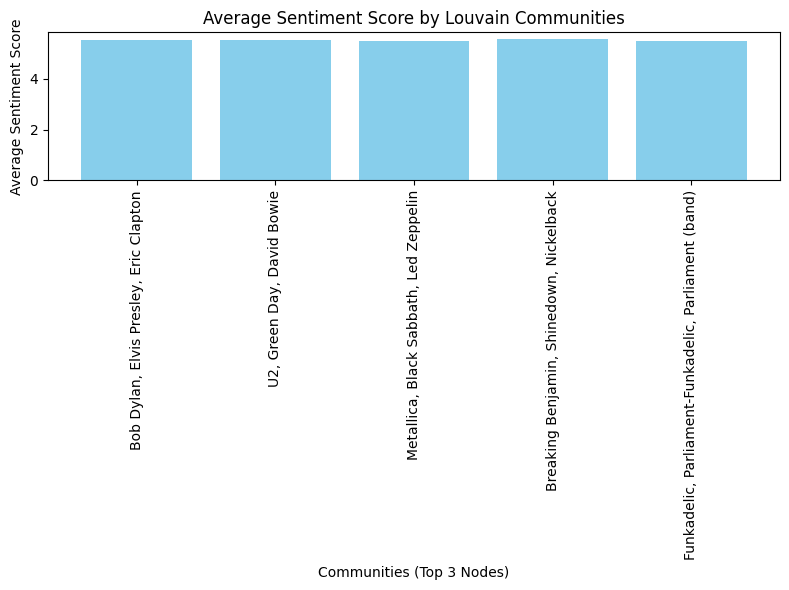

In [33]:
louvain_community_sentiments = []
for i, comm in enumerate(sorted_louvain_communities):
    comm_sentiments = []
    for node in comm:
        sentiment = G_genres.nodes[node].get('sentiment')
        if sentiment is not None:
            comm_sentiments.append(sentiment)
    if comm_sentiments:
        avg_sentiment = sum(comm_sentiments) / len(comm_sentiments)
    else:
        avg_sentiment = None
    louvain_community_sentiments.append((i, len(comm), avg_sentiment))

# name communities by the 3 most connected bands/nodes
comm_names = []
for i, comm in enumerate(sorted_louvain_communities):
    subgraph = G_genres.subgraph(comm)
    degrees = subgraph.degree()
    top_nodes = sorted(degrees, key=lambda x: x[1], reverse=True)[:3]
    name = ", ".join([n[0] for n in top_nodes])
    comm_names.append(name)

# Plot community sentiments
comm_ids = [c[0] for c in louvain_community_sentiments]
comm_sizes = [c[1] for c in louvain_community_sentiments]
comm_avg_sentiments = [c[2] for c in louvain_community_sentiments]

plt.figure(figsize=(8, 6))
plt.bar(comm_ids, comm_avg_sentiments, color='skyblue')
plt.xticks(comm_ids, comm_names, rotation=90)
plt.xlabel("Communities (Top 3 Nodes)")
plt.ylabel("Average Sentiment Score")
plt.title("Average Sentiment Score by Louvain Communities")
plt.tight_layout()
plt.show()

The bar plot displays the **average sentiment scores** for each of the five Louvain communities, which are labeled according to the **three nodes with the highest degree** in each.  
The sentiment scores are nearly identical across communities, indicating a **uniform distribution of sentiment** around 5.5 which is the artists mean score throughout the network.  
This suggests that the overall tone or descriptive sentiment associated with artists is consistent, regardless of their community grouping.

In [34]:
# Exercise: Who are the 10 artists with happiest and saddest pages?
from IPython.display import display

sorted_sentiment_bands = sorted(
    G_genres.nodes(data=True), key=lambda x: x[1].get("sentiment", np.nan)
)

# Get top 10 saddest and happiest
saddest_bands = [
    f"{band} ({data.get('sentiment'):.3f})" 
    for band, data in sorted_sentiment_bands[:10]
]

happiest_bands = [
    f"{band} ({data.get('sentiment'):.3f})" 
    for band, data in sorted_sentiment_bands[-10:][::-1]
]

# Create DataFrame
df_sentiment = pd.DataFrame({
    'Happiest Bands': happiest_bands,
    'Saddest Bands': saddest_bands
}, index=range(1, 11))

df_sentiment.index.name = 'Rank'

display(df_sentiment)

,Happiest Bands,Saddest Bands
Rank,,
1,Tracy Chapman (5.755),Five Finger Death Punch (5.270)
2,Boys Like Girls (5.746),Rage Against the Machine (5.327)
3,Lenny Kravitz (5.741),Canned Heat (5.351)
4,Volbeat (5.669),Marilyn Manson (5.364)
5,Kaiser Chiefs (5.669),Quiet Riot (5.371)
6,Fun (band) (5.666),Rob Zombie (5.372)
7,Living Colour (5.653),Gary Glitter (5.385)
8,Jimmy Eat World (5.649),Ted Nugent (5.390)
9,Finger Eleven (5.646),Traffic (band) (5.395)


### Exercise) Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

## Findings

### 1. Neutral Tone of Wikipedia
Wikipedia pages are intentionally written to maintain a neutral and factual tone. 
As a result, sentiment scores across pages tend to cluster around neutrality, with little emotional variation. We see that the median and the mean are exactly the same value and the distribution of sentiment scores is uniform.

### 2. High Vocabulary Overlap
The majority of words are shared among pages, as confirmed by word cloud analysis. 
This reflects the standardized structure and style of Wikipedia articles 
(e.g., sections like *Early Life*, *Discography*, *Reception*).

### 3. Consistent Node Sentiments
When evaluating each node (individual page) separately, sentiment scores remain very similar. 
This further supports the hypothesis that Wikipedia’s editorial guidelines minimize emotional language.

### 4. Community-Level Analysis Adds Little Value
Aggregating nodes into communities does not provide additional insight. 
Since nodes within a community have nearly identical sentiment distributions, 
the community sentiment averages out, revealing no meaningful differentiation between them.

### 5. Relation with TF-IDF

Term frequency alone does not capture what is distinctive about a text—it mainly reflects words that are frequent across all texts. In contrast, TF-IDF helps identify words that are **common within a specific genre** but **rare across others**. The inverse document frequency (IDF) component weights each word according to its rarity in a larger corpus, highlighting what makes each text distinctive and providing a better characterization of subsets of texts.

When we applied TF-IDF to texts grouped by genre, we found that the top-ranked words were mostly artists’ names. These appeared frequently on the artists’ own pages due to the high number of citations and references. Similarly, the sentiment analysis of the structural communities led to a comparable conclusion: there was no clear relationship between the sentiment of the words used to describe the artists on Wikipedia and the way they form structural communities. Likewise, there was no evident relationship between the artists’ genres and the language used to describe them within those genres.

### 6. Other findings

Building on the TF-IDF analysis, where the most relevant words associated with each genre were often the names of artists, we explored whether the most frequently cited artist names within each community were related to the community’s happiness level. To do so, we compared the average happiness of each community with the sentiment of its name, defined by the three most connected (and therefore most cited) artists within it. Although no clear correlation was found given that all communities sentiment scores are very close to the mean, the happiest community included name-matching words such as “david”, which showed higher sentiment scores than those in the saddest community, where the matching words included “black.”
